In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [ ]:
import addict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams["text.usetex"] = False

# Read in data files, create storage dictionaries, and do basic processing

In [ ]:
command_file_name = "../data/command/western_north_america_command.json"
command, segment, block, meshes, station, mogi, sar = celeri.read_data(command_file_name)
celeri.create_output_folder(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar) # Not sure this works correctly

# Get elastic operators and TDE smoothing operators

In [ ]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Calculate non-elastic operators

In [ ]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(station)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(station)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(assembly, block, command)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(assembly, segment, block, command)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(segment, block)
operators.block_strain_rate_to_velocities, strain_rate_block_index = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(mogi, station, command)
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Plot input data

In [ ]:
celeri.plot_input_summary(segment, station, block, meshes, mogi, sar, lon_range=(225, 250), lat_range=(30, 52), quiver_scale=1e2)

# Estimate block model parameters (dense)

In [ ]:
# Blocks only operator
index = celeri.get_index(assembly, station, block, meshes)
operator_block_only = celeri.get_full_dense_operator_block_only(operators, index)
weighting_vector = celeri.get_weighting_vector(command, station, meshes, index)
data_vector = celeri.get_data_vector(assembly, index)
weighting_vector_block_only = weighting_vector[0:operator_block_only.shape[0]]

In [ ]:
# Solve the overdetermined linear system using only a weighting vector rather than matrix
estimation = addict.Dict()
estimation.operator = operator_block_only
estimation.weighting_vector = weighting_vector_block_only

estimation.state_covariance_matrix = np.linalg.inv(operator_block_only.T * weighting_vector_block_only @ operator_block_only)
estimation.state_vector = estimation.state_covariance_matrix @ operator_block_only.T * weighting_vector_block_only @ data_vector[0:weighting_vector_block_only.size]


In [ ]:
# Post-processing

estimation.predictions = estimation.operator @ estimation.state_vector
estimation.vel = estimation.predictions[0 : 2 * index.n_stations]
estimation.east_vel = estimation.vel[0::2]
estimation.north_vel = estimation.vel[1::2]

# Estimate slip rate uncertainties
estimation.slip_rate_sigma = np.sqrt(
    np.diag(
        operators.rotation_to_slip_rate
        @ estimation.state_covariance_matrix[
            0 : 3 * index.n_blocks, 0 : 3 * index.n_blocks
        ]
        @ operators.rotation_to_slip_rate.T
    )
)  # I don't think this is correct because for the case when there is a rotation vector a priori
estimation.strike_slip_rate_sigma = estimation.slip_rate_sigma[0::3]
estimation.dip_slip_rate_sigma = estimation.slip_rate_sigma[1::3]
estimation.tensile_slip_rate_sigma = estimation.slip_rate_sigma[2::3]

# Calculate mean squared residual velocity
estimation.east_vel_residual = estimation.east_vel - station.east_vel
estimation.north_vel_residual = estimation.north_vel - station.north_vel

# Extract segment slip rates from state vector
estimation.slip_rates = (
    operators.rotation_to_slip_rate
    @ estimation.state_vector[0 : 3 * index.n_blocks]
)
estimation.strike_slip_rates = estimation.slip_rates[0::3]
estimation.dip_slip_rates = estimation.slip_rates[1::3]
estimation.tensile_slip_rates = estimation.slip_rates[2::3]

# Calculate rotation only velocities
estimation.vel_rotation = (
    operators.rotation_to_velocities[index.station_row_keep_index, :]
    @ estimation.state_vector[0 : 3 * index.n_blocks]
)
estimation.east_vel_rotation = estimation.vel_rotation[0::2]
estimation.north_vel_rotation = estimation.vel_rotation[1::2]

# Calculate fully locked segment velocities
estimation.vel_elastic_segment = (
    operators.rotation_to_slip_rate_to_okada_to_velocities[
        index.station_row_keep_index, :
    ]
    @ estimation.state_vector[0 : 3 * index.n_blocks]
)
estimation.east_vel_elastic_segment = estimation.vel_elastic_segment[0::2]
estimation.north_vel_elastic_segment = estimation.vel_elastic_segment[1::2]

# TODO: Calculate block strain rate velocities
estimation.east_vel_block_strain_rate = np.zeros(len(station))
estimation.north_vel_block_strain_rate = np.zeros(len(station))


In [ ]:
# celeri.post_process_estimation(estimation, operators, station, index)
# celeri.write_output(command, estimation, station, segment, block, meshes)

# Plot model summary 

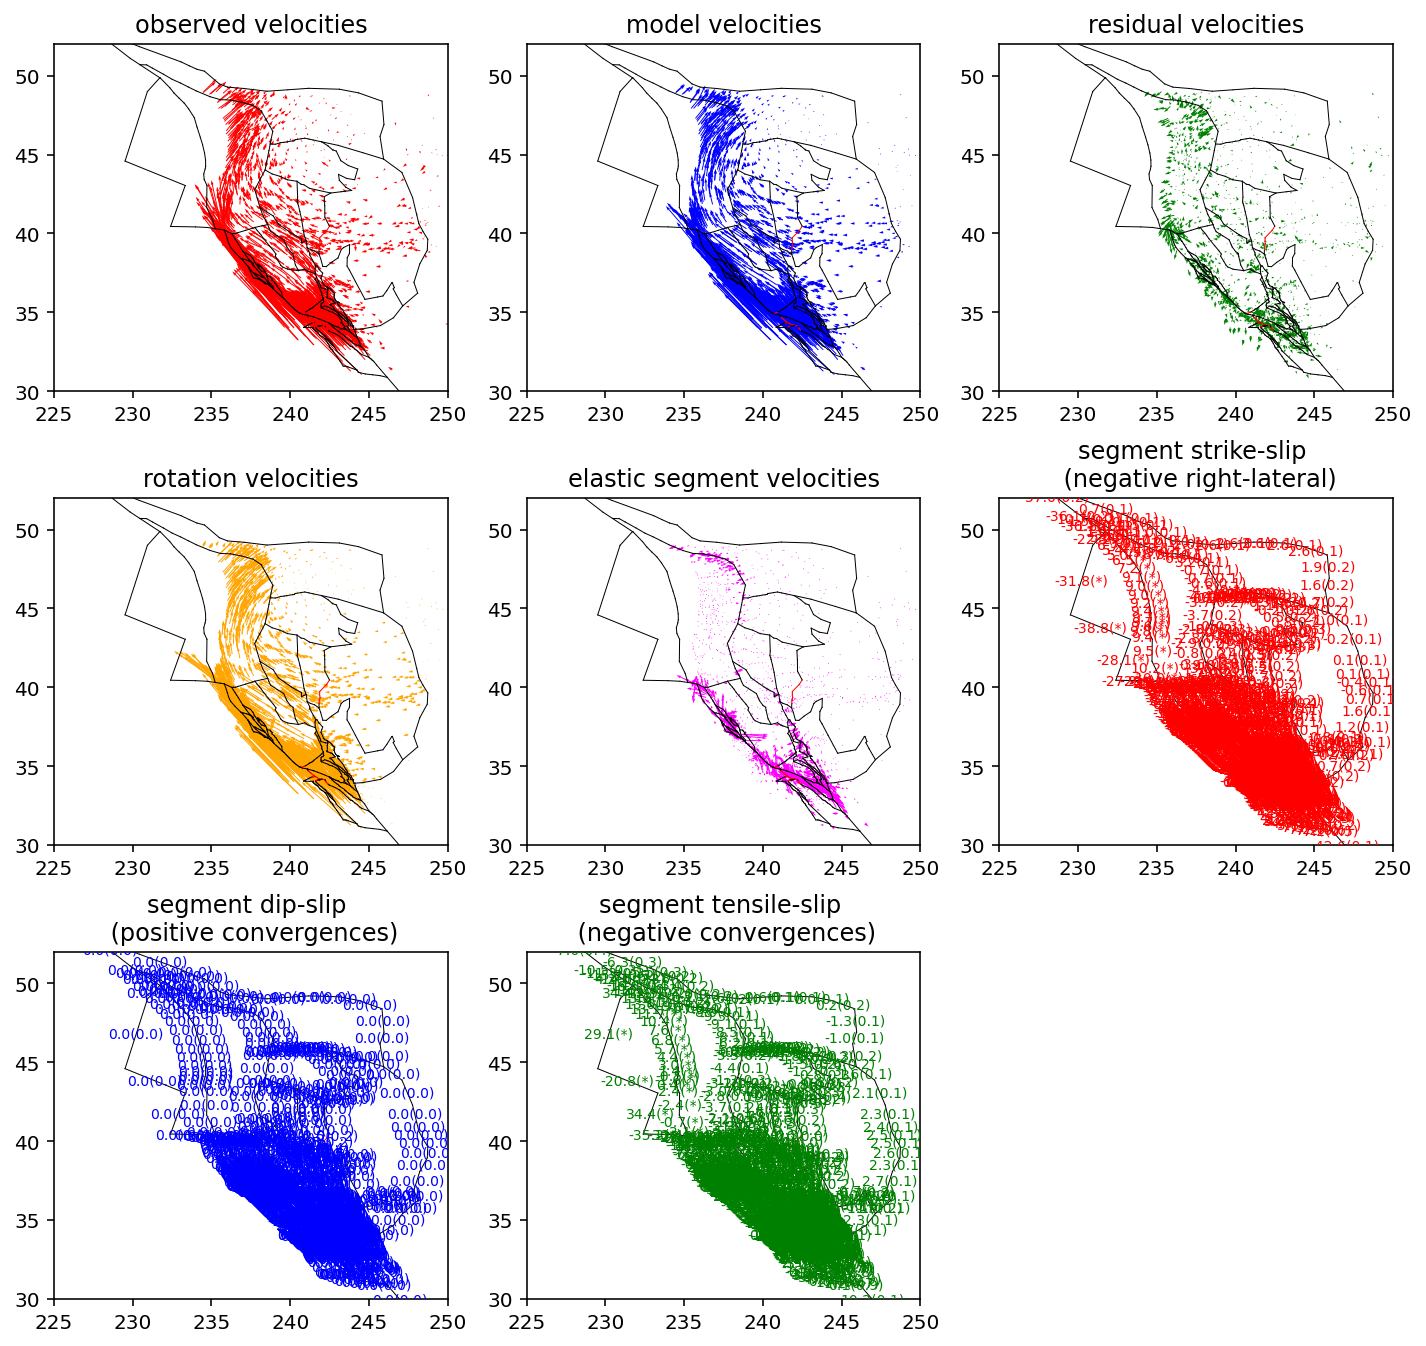

In [30]:
meshes = []
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=(225, 250), lat_range=(30, 52), quiver_scale=1e2)